In [5]:
import sys, cv2
import numpy as np
import tracktor_revised as tr
import matplotlib.pyplot as plt
import pickle
import os
import collections

In [ ]:
# Open video file.
video_file        = '../Data/SF_n2_t2_3113.mp4'
cap               = cv2.VideoCapture(video_file)
n_frames          = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps               = cap.get(cv2.CAP_PROP_FPS)
print(f'{n_frames} frames, {fps} frames per second.')

# Contour detection parameters.
block_size,offset = 15,13
min_area,max_area = 20,1000
n_pix             = 5

# Creating dataset from file

## Manually creates the fish data set from the video file. This cell is currently disabled. 

In [ ]:
# List of frames to analyze.
#frameID_list = range(5000,50000,50)
frameID_list = range(5000,n_frames,1)

# Data structure to hold only the pixels belonging to a fish and their brightness.
fish = []

#Uncomment line to make this cell run, commented to force notebook to use the .pkl file for speed. (This cell takes over an hour.)
#for i in frameID_list:
    
    # Load the frame.
    cap.set(cv2.CAP_PROP_POS_FRAMES, i-1)
    ret,frame = cap.read()
    
    # Detect the contours.
    contours  = tr.contour_detect(frame,min_area,max_area,block_size,offset,n_pix)
    
    # Make a mask with value j inside fish number j and -1 elsewhere. 
    mask      = 0*cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY) - 1
    for j in range(len(contours)):
        cv2.drawContours(mask, contours, j, j, -1)
    
    # Make and save a list of each fish's pixels.
    pixels=[]
    subFish=[]
    for j in range(len(contours)):
        pixels=(np.nonzero(mask==j))
        n =len(pixels[0]) # Number of pixels in J
        subSubFish=[]
        for k in range(n):
            row=pixels[0][k]
            col=pixels[1][k]
            rgb=frame[row,col]
            grey=round(.3*rgb[0]+.59*rgb[1]+.11*rgb[2],2)
            subSubFish.append([row,col,grey]) #Pixel
        subFish.append(np.array(subSubFish)) #Fish
    fish.append(subFish) #Frame

with open('fish.pkl','wb') as fh:
     pickle.dump(fish,fh)

## Reads fish.pkl to create fish.

In [6]:
with open('fish.pkl','rb') as fh:
     fish=pickle.load(fh)

# Fish Overlap Check

## Checks fish for sections where the program is reading the fish as one object due to proximity, and returns a list of where the fish are not overlapping.

In [8]:
i2=0
nonOverlappingRange=[]
while i2<len(fish):
    i1=i2
    while i1<len(fish) and len(fish[i1])!=2:
        i1+=1
    i2=i1
    while i2 < len(fish) and len(fish[i2])==2:
        #find the first overlapping index
        i2+=1
    nonOverlappingRange.append([i1,i2])
print(nonOverlappingRange)

[[0, 137], [138, 204], [207, 247], [248, 371], [379, 624], [625, 916], [918, 1164], [1168, 1203], [1205, 1345], [1351, 1380], [1382, 1804], [1815, 1825], [1826, 2707], [2710, 2785], [2792, 3048], [3061, 3229], [3230, 3233], [3236, 3290], [3295, 3595], [3597, 3598], [3602, 3658], [3661, 3733], [3738, 3770], [3774, 3781], [3788, 3896], [3898, 3918], [3920, 4062], [4068, 4155], [4157, 4389], [4390, 4551], [4552, 4589], [4591, 5152], [5155, 6433], [6434, 6436], [6437, 8500], [8501, 8536], [8549, 8945], [8948, 9123], [9141, 9508], [9539, 9571], [9697, 9947], [9952, 10030], [10040, 10095], [10112, 10208], [10216, 11231], [11235, 11646], [11648, 11653], [11654, 12363], [12364, 12427], [12430, 12567], [12574, 12995], [13006, 13076], [13081, 13913], [13914, 14436], [14439, 14536], [14543, 14580], [14581, 14583], [14584, 14681], [14692, 15300], [15304, 15466], [15470, 15600], [15603, 15826], [15829, 16667], [16671, 17110], [17117, 17463], [17465, 17657], [17660, 17768], [17783, 17947], [17955, 1

## Checks to see that the nonOverlappingRange was created correctly.

In [9]:
#Only prints sections where the number is repeated
for i in range(1,len(nonOverlappingRange)-1):
    if nonOverlappingRange[i][:-1] and not nonOverlappingRange[i][1:]:
        print(i)

## Finds the longest consuctive streach where the fish are not overlapping.

In [7]:
#Take a list of each strech where the fish don't cross so that we can check which fish is which after they cross by comparing it to either the first or the longest streach uncrossed
#See 1 on fily's paper
longestDistance=[]
distance=0
for i in range(len(nonOverlappingRange)):
    if (nonOverlappingRange[i][-1]-nonOverlappingRange[i][0])>distance:
        distance=(nonOverlappingRange[i][-1]-nonOverlappingRange[i][0])
        longestDistance=[distance,i,nonOverlappingRange[i][-1],nonOverlappingRange[i][0]]
print(longestDistance)

[2481, 93, 26589, 24108]


## Finds the center of each fish.

In [12]:
#finding the center of each fish
#2 on fily's paper
fishMean=[]
for i in range(len(fish)):
    if len(fish[i])==1:
        fishMean.append([[np.mean(fish[i][0].T[0]),np.mean(fish[i][0].T[1])],[np.mean(fish[i][0].T[0]),np.mean(fish[i][0].T[1])]])
    else:
        fishMean.append([[np.mean(fish[i][0].T[0]),np.mean(fish[i][0].T[1])],[np.mean(fish[i][1].T[0]),np.mean(fish[i][1].T[1])]])
fishMean=np.asarray(fishMean)
#fishMean[i.j.k] is the coordianate of k of the position of fjsh j in frame i

## Plots the paths of the two fish using their centers.

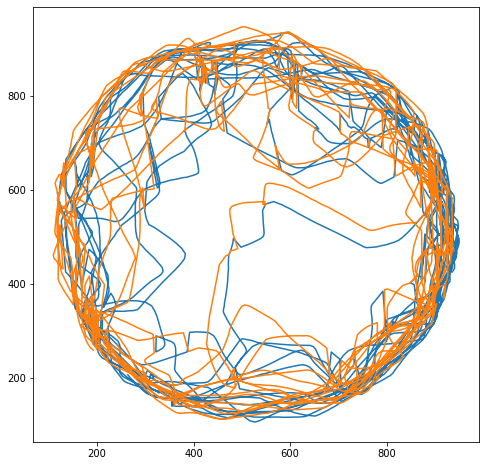

In [11]:
plt.figure(figsize=(8,8))
I = slice(0,5000)
plt.plot(fishMean[I,0,0],fishMean[I,0,1])
plt.plot(fishMean[I,1,0],fishMean[I,1,1])
plt.show()

## Measures the distance between each fish during each nonoverlapping section to vertifiy that they are the same fish.

In [14]:
def swapStatus(pos,i):
    '''
    Detext swaps between consicutivve framses based on proximity.
    
    Input:
        pos:Postionts. Array with shape (Nframes,Nfish,Ndimensions),
        i: Frame index. Int.
    
    Output:
        Int. 0 if no swaps, 1 if swapped, 2 if overlapping.
    '''
    nFish=pos.shape[1] #Number of fish
    distanceMatrix=[np.linalg.norm(pos[i+1][0]-pos[i][0]),
                    np.linalg.norm(pos[i+1][1]-pos[i][1]),
                    np.linalg.norm(pos[i+1][0]-pos[i][1]),
                    np.linalg.norm(pos[i+1][1]-pos[i][0])]
    swapCriteron=(distanceMatrix[0]+distanceMatrix[1])-(distanceMatrix[2]+distanceMatrix[3])
    if abs(swapCriteron)<1e-10:
        return 2 #Overlapping
    elif swapCriteron>0:
        return 1 #Swapped
    elif swapCriteron<0:
        return 0 #Normal
    else:
        return -1

In [13]:
def normFunc(pos,i):
    '''
    Returns the distance between all possible combinations of 4 points to check whether the on or off axis diatance is larger.
    
    Input:
        i: Index, int.
    
    Output:
        1x4 list of distances.
    '''
    return [np.linalg.norm(pos[i+1][0]-pos[i][0]),
           np.linalg.norm(pos[i+1][1]-pos[i][1]),
           np.linalg.norm(pos[i+1][0]-pos[i][1]),
           np.linalg.norm(pos[i+1][1]-pos[i][0])]


fishQuadDistance=[]
for i in range(len(fishMean)-1):
    #print(i,j)
    fishQuadDistance.append(np.array(normFunc(fishMean,i)))
fishQuadDistance=np.array(fishQuadDistance)

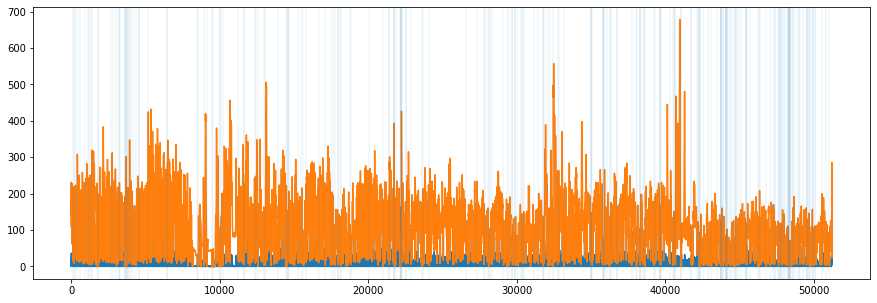

In [17]:
plt.figure(figsize=(15,5))
plt.plot(fishQuadDistance[:,1]+fishQuadDistance[:,0],label='diagonal')
plt.plot(fishQuadDistance[:,2]+fishQuadDistance[:,3],label='offdiagonal')
for i in range(len(nonOverlappingRange)-1):
    plt.axvline(x=nonOverlappingRange[i][1],linewidth=.1)
plt.show()

In [ ]:
#Checks if each frame has been swapped in the origional data
statusList=[]
for i in range(len(fishMean)-1):
    statusList.append(swapStatus(fishMean,i))

print(collections.Counter(statusList))

## Unswapping the fish

Commented out for test version

In [15]:
# pos=fishMean

# #Checks for swqps and creates list of swaped points
# i=0
# I=[]
# while i < len(pos):
#     j=i+1
#     while j<len(pos)-1 and swapStatus(pos,j)!=1:
#         j+=1
#     i=j+1
#     while i<len(pos)-1 and swapStatus(pos,i)!=1:
#         i+=1
#     I.append([j+1,i+1])
# del(I[-1])

In [57]:
pos=fishMean

#Checks for swqps and creates list of swaped points
i=0
I=[]
ia=[]
ja=[]
while i < len(pos):
    j=i+1
    while j<len(pos)-1 and swapStatus(pos,j)!=1:
        j+=1
        ja.append(j)
    i=j+1
    while i<len(pos)-1 and swapStatus(pos,i)!=1:
        i+=1
        ia.append(i)
    I.append([j+1,i+1])
#del(I[-1])
print(ja[-5:])
print(ia[-5:])
print(I[-5:])
print(pos.shape)

[51016, 51017, 51018, 51019, 51213]
[51207, 51208, 51209, 51210, 51211]
[[50410, 50450], [50460, 50564], [50756, 50956], [51020, 51212], [51214, 51215]]
(51214, 2, 2)


In [18]:
posU=fishMean.copy()
for j,i in I:
    posU[j:i,:]=pos[j:i,[1,0]]

status=[]
for i in range(len(posU)-1):
    status.append(swapStatus(posU,i))

print(collections.Counter(status))

Counter({0: 49283, 2: 1930})


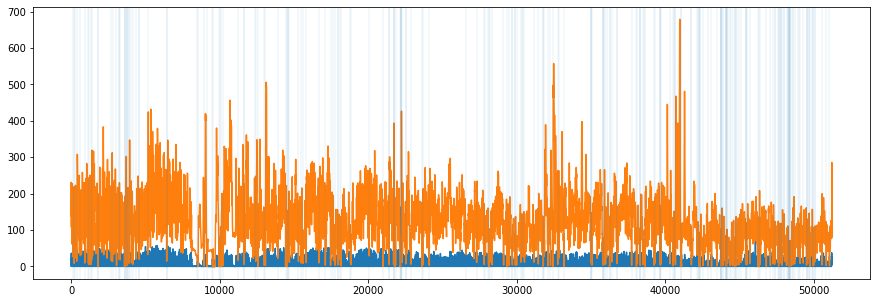

In [26]:
fishQuadDistance1=[]
for i in range(len(posU)-1):
    fishQuadDistance1.append(np.array(normFunc(posU,i)))
fishQuadDistance1=np.array(fishQuadDistance1)

plt.figure(figsize=(15,5))
plt.plot(fishQuadDistance1[:,1]+fishQuadDistance1[:,0],label='diagonal')
plt.plot(fishQuadDistance1[:,2]+fishQuadDistance1[:,3],label='offdiagonal')
for i in range(len(nonOverlappingRange)-1):
    plt.axvline(x=nonOverlappingRange[i][1],linewidth=.1)
plt.show()

### Unswapping the origional fish file

In [16]:
fishU=fish
for i1,i2 in I:
    for i in range(i1,i2):
        if len(fishU[i])==2:
            fishU[i][0]=fish[i][1]
            fishU[i][1]=fish[i][0]

## Creates histograms of the frames on either side of the overlap, and then computes the distance between them.

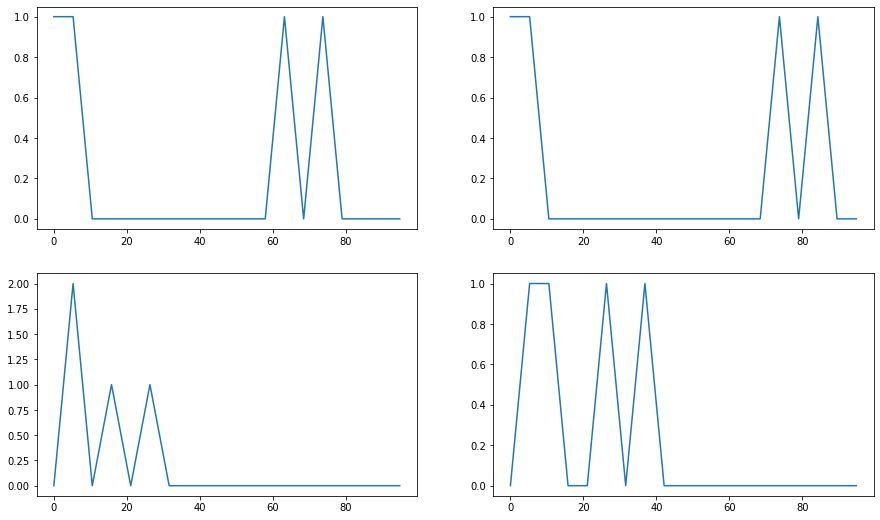

In [27]:
#plots the histograms at the first 2 nonOverlappingRanges
plt.figure(figsize=(15,9))
bins=np.linspace(0,100,20)

plt.subplot(2,2,1)
distHist=np.histogram(fishQuadDistance1[0:137][0:1],bins=bins)
plt.plot(distHist[1][:-1],distHist[0])

plt.subplot(2,2,2)
distHist2=np.histogram(fishQuadDistance1[0:137][2:3],bins=bins)
plt.plot(distHist2[1][:-1],distHist2[0])

plt.subplot(2,2,3)
distHist1=np.histogram(fishQuadDistance1[138:204][0:1],bins=bins)
plt.plot(distHist1[1][:-1],distHist1[0])

plt.subplot(2,2,4)
distHist3=np.histogram(fishQuadDistance1[138:204][2:3],bins=bins)
plt.plot(distHist3[1][:-1],distHist3[0])

plt.show()

In [28]:
distList=[]
for i in range(len(nonOverlappingRange)-1):
    distHist=np.histogram(fishQuadDistance1[nonOverlappingRange[i][0]:nonOverlappingRange[i][1]][0:1])
    distHist1=np.histogram(fishQuadDistance1[nonOverlappingRange[i][0]:nonOverlappingRange[i][1]][2:3])
    distHist2=np.histogram(fishQuadDistance1[nonOverlappingRange[i+1][0]:nonOverlappingRange[i+1][1]][0:1])
    distHist3=np.histogram(fishQuadDistance1[nonOverlappingRange[i+1][0]:nonOverlappingRange[i+1][1]][2:3])
    distList.append([np.linalg.norm(distHist[1]-distHist2[1]),np.linalg.norm(distHist1[1]-distHist3[1]),np.linalg.norm(distHist1[1]-distHist2[1]),np.linalg.norm(distHist[1]-distHist3[1])])
distList=np.array(distList)
print(distList[:5])

[[ 83.70360045  90.47824199 105.42488548  68.76801471]
 [ 21.46069665  35.66669034  10.75958369  50.30684399]
 [ 12.84830518  15.73549083  43.39277514  14.92983587]
 [  7.47118388  18.98405996  33.54865336   9.97057494]
 [ 10.5372243    7.80089153   6.02792719   6.85057269]]


In [29]:
checkList=[]
for i in range(len(distList)):
    if np.mean([distList[i][0],distList[i][1]])>np.mean([distList[i][2],distList[i][3]]):
        checkList.append(0)
    elif np.mean([distList[i][2],distList[i][3]])<np.mean([distList[i][0],distList[i][1]]):
        checkList.append(1)
    else: 
        checkList.append(2)
print(collections.Counter(checkList))

Counter({2: 141, 0: 109})


# Dumping resultant data

Dumps the sorted fishmeans and the nonOverlappingRange in a pickle file with [posU,nonOverlappingRange]

In [19]:
sortedFish=[posU,nonOverlappingRange,fishU]

with open('sortedFish.pik','wb') as f:
    pickle.dump(sortedFish,f)

# Reading Dumped data

In [21]:
with open('sortedFish.pik','rb') as f:
    sortedFish=pickle.load(f)

posU=sortedFish[0]
nonOverlappingRange=sortedFish[1]
fishU=sortedFish[2]

# Creating a distance histogram out of the sorted data

In [ ]:
pairFrameData=[]
for i in range(0,1000):
    for j in range(i):
        distance=np.sqrt((fishU[i][0][0][0]-fishU[j][0][0][0])**2+(fishU[i][0][0][1]-fishU[j][0][0][1])**2)
        brightness=fishU[i][0][0][2]+fishU[j][0][0][2]
        difference=np.absolute(fishU[i][0][0][2]-fishU[j][0][0][2])
        pairFrameData.append([distance,brightness,difference])
print(pairFrameData[0])
pairFrameData=np.array(pairFrameData).T

In [100]:
print(pairFrameData[2])
print(fishU[0][0])
print(fishU[0][0][0])
#frame,fish,pixel

[[  6.40312424   6.40312424   6.40312424 ...   6.40312424   6.40312424
    6.40312424]
 [278.78       272.96       275.96       ... 261.03       260.63
  262.63      ]
 [  8.61         8.61         8.61       ...   8.61         8.61
    8.61      ]]
[[256.   214.   134.89]
 [256.   215.   135.89]
 [256.   216.   137.89]
 [256.   217.   140.89]
 [257.   213.   130.07]
 [257.   214.   126.89]
 [257.   215.   130.89]
 [257.   216.   134.89]
 [258.   211.   134.49]
 [258.   212.   129.49]
 [258.   213.   123.49]
 [258.   214.   126.49]
 [258.   215.   135.49]
 [258.   216.   141.49]
 [259.   209.   124.27]
 [259.   210.   122.49]
 [259.   211.   117.49]
 [259.   212.   119.49]
 [259.   213.   122.49]
 [259.   214.   126.49]
 [259.   215.   138.49]
 [260.   207.   133.27]
 [260.   208.   123.27]
 [260.   209.   116.27]
 [260.   210.   116.5 ]
 [260.   211.   116.5 ]
 [260.   212.   120.1 ]
 [260.   213.   129.1 ]
 [260.   214.   135.1 ]
 [261.   206.   128.27]
 [261.   207.   121.27]
 [261.

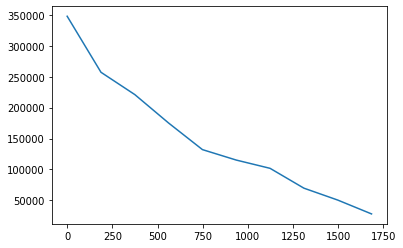

ValueError: too many values to unpack (expected 2)

In [89]:
#Works
histArray=np.histogram(pairFrameData[0])
plt.plot(histArray[1][:-1],histArray[0])
plt.show()

#?
#heightValuesSum,bin1Sum,bin2sum=np.histogram2d(pairFrameData[0],pairFrameData[1])
#plt.hist2d(pairFrameData[0],pairFrameData[1])
# plt.show()

heightValuesDifference,bin1Difference,bin2Difference=np.histogram2d(pairFrameData[0],pairFrameData[2])
# plt.hist2d(pairFrameData[0],pairFrameData[2])
# plt.show()